Accuracy: 0.9838709677419355

Classification report (threshold = 0.30):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1198
           1       0.93      0.97      0.95       910

    accuracy                           0.96      2108
   macro avg       0.95      0.96      0.96      2108
weighted avg       0.96      0.96      0.96      2108



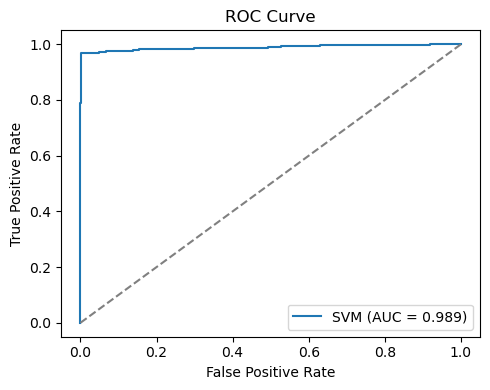

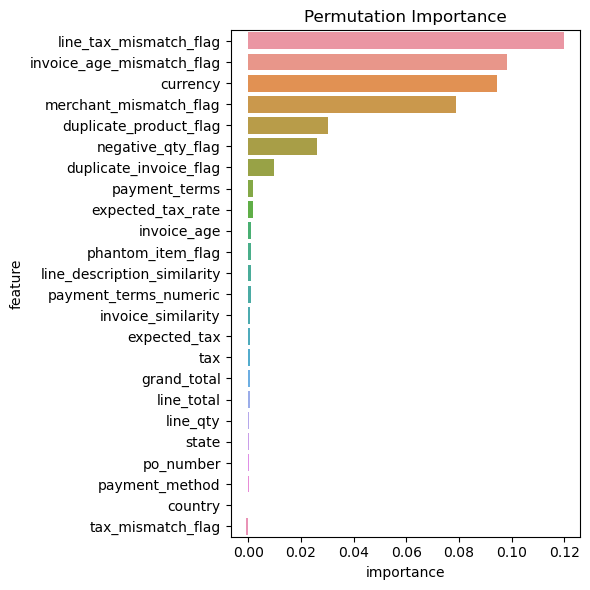

In [1]:
##############################################################################
# --- imports ---------------------------------------------------------------
##############################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.svm            import SVC
from sklearn.preprocessing   import LabelEncoder, StandardScaler
from sklearn.decomposition   import PCA
from sklearn.metrics         import (accuracy_score, classification_report,
                                     confusion_matrix, roc_curve, auc)
from sklearn.inspection      import permutation_importance
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.model_selection import train_test_split

##############################################################################
# --- data loading & identical preprocessing --------------------------------
##############################################################################
df_train = pd.read_parquet("train_df.parquet", engine="pyarrow")
df_test  = pd.read_parquet("test_df.parquet",  engine="pyarrow")

X_train = df_train.drop(
    ["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1,
    errors="ignore"
)
y_train = df_train["is_anomalous"]
X_test  = df_test.drop(
    ["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1,
    errors="ignore"
)
y_test  = df_test["is_anomalous"]

##############################################################################
# --- label‑encode categoricals (same as original) --------------------------
##############################################################################
label_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
encoders   = {}
for col in label_cols:
    enc       = LabelEncoder()
    combined  = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    enc.fit(combined)
    X_train[col] = enc.transform(X_train[col].astype(str))
    X_test[col]  = enc.transform(X_test[col].astype(str))
    encoders[col] = enc

# drop text / date columns you said are not informative
drop_cols = [
    "merchant", "merchant_branch", "merchant_chain", "merchant_address",
    "invoice_date", "due_date"
]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_test  = X_test.drop(columns=drop_cols, errors="ignore")

##############################################################################
# --- scaling + PCA + SVM  ---------------------------------------------------
##############################################################################
scaler = StandardScaler()
pca    = PCA(n_components=10, random_state=42)
svm    = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    class_weight="balanced",
    probability=True,
    random_state=42
)

# Fit
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
X_train_pca    = pca.fit_transform(X_train_scaled)
X_test_pca     = pca.transform(X_test_scaled)

svm.fit(X_train_pca, y_train)
y_pred      = svm.predict(X_test_pca)
y_proba     = svm.predict_proba(X_test_pca)[:, 1]
y_pred_thr  = (y_proba >= 0.30).astype(int)     # same 0.3 threshold

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report (threshold = 0.30):")
print(classification_report(y_test, y_pred_thr))


##############################################################################
# --- 1) ROC curve & AUC -----------------------------------------------------
##############################################################################
fpr, tpr, thresh = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"--",color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

##############################################################################
# --- 2) Feature‑importance proxy (permutation importance)  ------------------
# NOTE: importance is computed on ORIGINAL features, not PCA components,
#       because that is easier to interpret.
##############################################################################
pipe = Pipeline(
    steps=[
        ("scale", StandardScaler()),
        (
            "svm",
            SVC(
                kernel="rbf",
                C=1.0,
                gamma="scale",
                class_weight="balanced",
                probability=True,
                random_state=42,
            ),
        ),
    ]
)

pipe.fit(X_train, y_train)  # <<< this line fixes the NotFittedError

perm = permutation_importance(
    pipe,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1,
)

perm_df = (
    pd.DataFrame(
        {
            "feature": X_test.columns,
            "importance": perm.importances_mean,
        }
    )
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(6, 6))
sns.barplot(
    data=perm_df,
    x="importance",
    y="feature",
    orient="h",
)
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()
